In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")
import numpy.random as rng
import numpy.linalg as lin
import control as cm
from helperFunctions import *
setPlotStyle()


 ## Observe this

 Reality is here to ruin our day again. Practically, we never know/measure the full state, so $u=-Kx$ doesn't really work, because we don't know $x$. That means everything that we've done up to now only exists in the realms of mathematics. But our trickery is endless! We'll say that we have an **estimate** of the state, $\hat x$. We'll also say that we have an estimation error $\tilde x = x - \hat x$. Lastly, we make a *Luenberger observer*, $L$, that's implemented as

 $$\dot{\hat x} = A\hat x + B u + L(y − C \hat x).$$

 Now it's that time again, our favourite time, substitution time!

 $$\dot{\hat x} = A\hat x + B u + L(y − C \hat x) = A\hat x + B u + LC(x − \hat x) = A\hat x + B u + LC\tilde x$$

 $$\Rightarrow \dot x - \dot{\hat x} = \dot{\tilde x} = Ax + Bu - A\hat x - B u - LC\tilde x = A(x − \hat x) - LC\tilde x = A\tilde x - LC\tilde x = (A-LC)\tilde x.$$



 Wait, that's familiar! That looks a whole lot like controller pole placement! That is because there is a duality between Luenberger observers and state feedback controllers, practically anything you can do for controllers/controlability with the pair $(A,B)$, you can do for observers/observability with the pair $(A^\intercal, C^\intercal)$.



 Looking at that last equation written above,

 $$\dot{\tilde x} = (A-LC)\tilde x,$$

 it is very reminiscent of the state feedback controllers that were expressed earlier as

 $$ \dot x = (A-BK) x.$$

 Taking the transpose of the error dynamics equations reveals the true duality between $L$ and $K$:

 $$\dot{\tilde x}^\intercal = \tilde x^\intercal (A^\intercal-C^\intercal L^\intercal).$$

 Here you see that pair $(A^\intercal, C^\intercal)$ appear. If we design $L^\intercal$ such that the error dynamics are asymptotically stable, then the error goes to zero asymptotically. That means that we quickly get a good estimate of the state that we can use for state feedback control.



 So we have

 | Control   | Observe   | 
 | --------- | --------- | 
 | $${K=\texttt{cm.place}(A,B,p)}$$      | $$L.T = \texttt{cm.place}(A.T, C.T, p)$$      | 
 | $$W_r = \begin{bmatrix}B & AB & \cdots & A^{n-1}B\end{bmatrix}$$ | $$W_o^\intercal = \begin{bmatrix}C^\intercal & (CA)^\intercal & \cdots & (CA^{n-1})^\intercal\end{bmatrix}$$ |



 This *observability matrix*, $W_o$, is the dual twin of the controlability matrix. If it has full rank, the system is *observable*.



 So what does this do in practise? Lets make some observers! One trick we need to program this though is the augmentation of the state space with the estimate dynamics, i.e.

 $$\begin{bmatrix}\dot x \\ \dot{\hat x} \end{bmatrix} = \begin{bmatrix}A&0\\ LC & A - LC\end{bmatrix}\begin{bmatrix} x \\ \hat x \end{bmatrix} + \begin{bmatrix}B \\ B \end{bmatrix} u$$

 $$y = \begin{bmatrix}C & 0 \end{bmatrix}\begin{bmatrix} x \\ \hat x \end{bmatrix}.$$



<IPython.core.display.Javascript object>

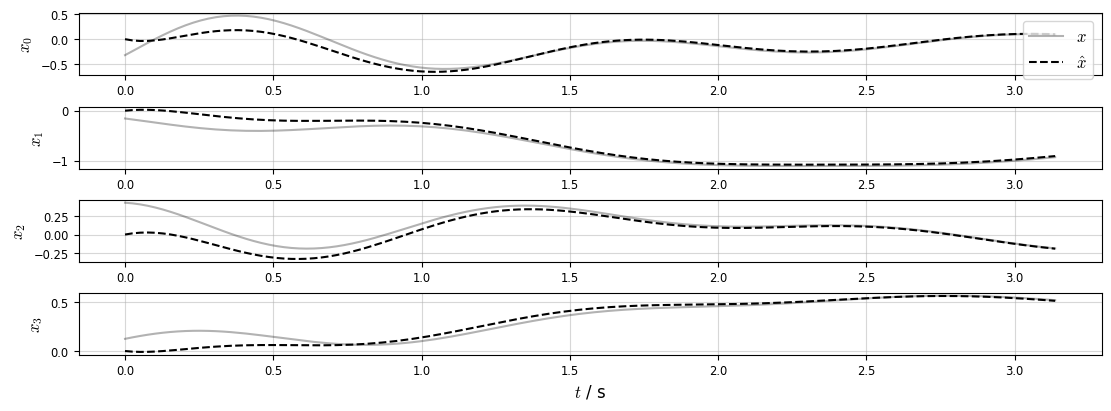

In [2]:
P_obs = cm.rss(4, strictly_proper=True)
nx = len(P_obs.poles())
x0 = rng.randn(nx,1)

T_obs = np.linspace(0., 5./abs(P_obs.poles().real.max()), 400)

## Check observability!
def isObservable(A, C):
    Wo = cm.obsv(A, C)
    return lin.matrix_rank(Wo) == A.shape[0]

assert isObservable(P_obs.A, P_obs.C)==True, "System is unobservable D:"

obsv_poles = np.linspace(-1., -3, nx)
L = cm.place(P_obs.A.transpose(), P_obs.C.transpose(), obsv_poles).transpose()

P_obs_aug = cm.ss(np.block([[P_obs.A,      np.zeros_like(P_obs.A)], # A
                        [L@P_obs.C,    P_obs.A - L@P_obs.C]]),
              np.vstack((P_obs.B, P_obs.B)), # B
              np.hstack((P_obs.C, np.zeros_like(P_obs.C))), # C
              [[0]]) # D


obsIn = np.sin(T_obs)**1.7
response_obs = cm.forced_response(P_obs_aug, 
                                 T=T_obs, 
                                 U=obsIn, 
                                 X0=np.vstack((rng.randn(nx,1), np.zeros([nx,1])))) # Nonzero initialisation!

fig, ax = plt.subplots(nx, 1)
for idx in range(nx-1):
    ax[idx].plot(response_obs.time, response_obs.states[idx, :], 'k', alpha=.3)
    ax[idx].plot(response_obs.time, response_obs.states[idx+nx, :], 'k--')
    ax[idx].set_ylabel(f"$x_{idx}$")

ax[0].legend(handles=[
    ax[nx-1].plot(response_obs.time, response_obs.states[nx-1, :], 'k', alpha=.3, label=r"$x$")[0],
    ax[nx-1].plot(response_obs.time, response_obs.states[nx-1+nx, :], 'k--', label=r"$\hat x$")[0]
    ])
ax[nx-1].set(ylabel = f"$x_{nx-1}$", xlabel = "$t$ / s")
display(fig)


 ### Quicker than thou

 So if you run the previous cell a few times, you'll see that the performance of the observer can vary wildly. Why is that? Well it depends on how fast the system is in comparison to the observer: if the system dynamics are faster than the observer, the state will change faster than the error can go to zero, resulting in poor estimates. Lets see what that looks like in a more structured way:

<IPython.core.display.Javascript object>

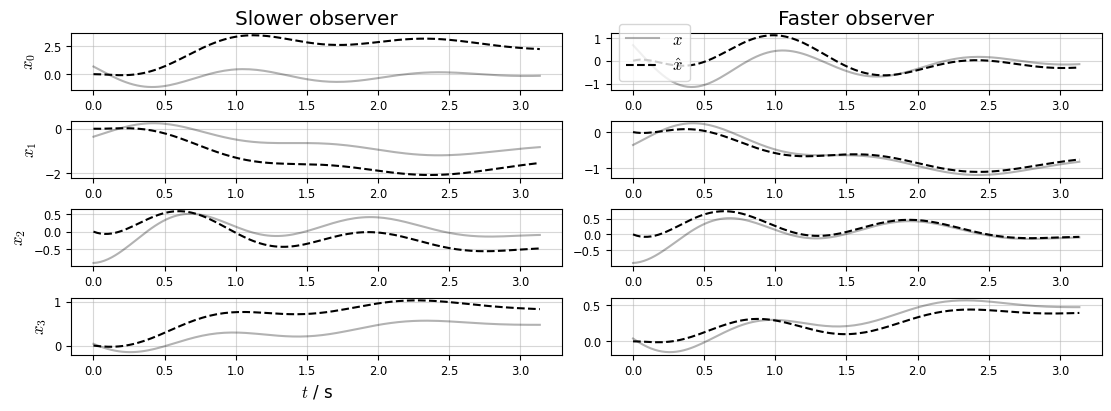

<IPython.core.display.Javascript object>

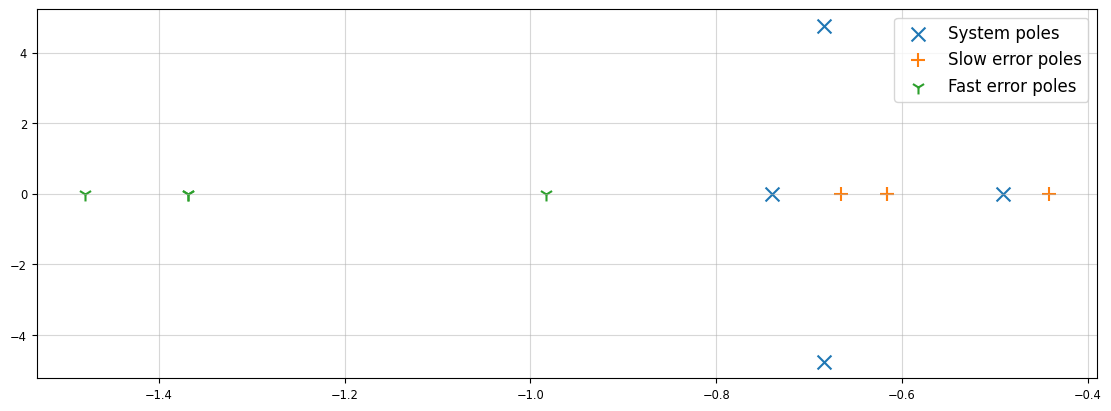

In [14]:
obsv_poles_slow = P_obs.poles().real * .9 + P_obs.poles().imag * 1e-5
obsv_poles_fast = P_obs.poles().real * 2. + P_obs.poles().imag * 1e-5
L_slow = cm.place(P_obs.A.transpose(), P_obs.C.transpose(), obsv_poles_slow).transpose()
L_fast = cm.place(P_obs.A.transpose(), P_obs.C.transpose(), obsv_poles_fast).transpose()

T_obs = np.linspace(0., 10./abs(obsv_poles_fast.real.max()), 400)
obsIn = np.sin(T_obs)**1.7

P_obs_aug_slow = cm.ss(np.block([[P_obs.A,      np.zeros_like(P_obs.A)], # A
                                 [L_slow@P_obs.C,    P_obs.A - L_slow@P_obs.C]]),
                            np.vstack((P_obs.B, P_obs.B)), # B
                            np.hstack((P_obs.C, np.zeros_like(P_obs.C))), # C
                            [[0]]) # D

P_obs_aug_fast = cm.ss(np.block([[P_obs.A,      np.zeros_like(P_obs.A)], # A
                                 [L_fast@P_obs.C,    P_obs.A - L_fast@P_obs.C]]),
                            np.vstack((P_obs.B, P_obs.B)), # B
                            np.hstack((P_obs.C, np.zeros_like(P_obs.C))), # C
                            [[0]]) # D

X0 = np.vstack((rng.randn(nx,1), np.zeros([nx,1]))) # Nonzero initialisation!
response_obs_slow = cm.forced_response(P_obs_aug_slow, 
                                        T=T_obs, 
                                        U=obsIn, 
                                        X0=X0) 
response_obs_fast = cm.forced_response(P_obs_aug_fast, 
                                        T=T_obs, 
                                        U=obsIn, 
                                        X0=X0) 

fig, ax = plt.subplots(nx, 2)
for idx in range(nx-1):
    ax[idx, 0].plot(response_obs_slow.time, response_obs_slow.states[idx, :], 'k', alpha=.3)
    ax[idx, 0].plot(response_obs_slow.time, response_obs_slow.states[idx+nx, :], 'k--')
    ax[idx, 1].plot(response_obs_fast.time, response_obs_fast.states[idx, :], 'k', alpha=.3)
    ax[idx, 1].plot(response_obs_fast.time, response_obs_fast.states[idx+nx, :], 'k--')
    ax[idx, 0].set_ylabel(f"$x_{idx}$")

ax[0, 1].legend(handles=[
    ax[nx-1,0].plot(response_obs_slow.time, response_obs_slow.states[nx-1, :], 'k', alpha=.3, label=r"$x$")[0],
    ax[nx-1,0].plot(response_obs_slow.time, response_obs_slow.states[nx-1+nx, :], 'k--', label=r"$\hat x$")[0]
    ])
ax[nx-1,1].plot(response_obs_fast.time, response_obs_fast.states[nx-1, :], 'k', alpha=.3, label=r"$x$")[0]
ax[nx-1,1].plot(response_obs_fast.time, response_obs_fast.states[nx-1+nx, :], 'k--', label=r"$\hat x$")[0]
_ = ax[nx-1,0].set(ylabel = f"$x_{nx-1}$", xlabel = "$t$ / s")

ax[0,0].set_title("Slower observer")
ax[0,1].set_title("Faster observer")

e_slow = lin.eigvals(P_obs.A - L_slow @ P_obs.C)
e_fast = lin.eigvals(P_obs.A - L_fast @ P_obs.C)
display(fig)

fig, ax = plt.subplots()
ax.legend(handles= [
    ax.scatter(P_obs.poles().real, P_obs.poles().imag, s=100, marker='x', color='tab:blue', label="System poles"),
    ax.scatter(e_slow.real, e_slow.imag, s=100, marker='+', color='tab:orange', label="Slow error poles"),
    ax.scatter(e_fast.real, e_fast.imag, s=100, marker='1', color='tab:green', label="Fast error poles"),
])
display(fig)



 <div style="text-align:center;background-color:tomato;">End of lecture 8</div>